In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
print("Using torch", torch.__version__)
import seaborn as sns
import torchvision.datasets as datasets
from torchvision import transforms
sns.set()
torch.manual_seed(42) # Setting the seed

Using torch 2.1.2+cu118


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device cuda


In [3]:
#Dataset Load:
#Load the MNIST dataset:
from torch.utils.data import DataLoader, random_split

tr = transforms.Compose([
    transforms.ToTensor()
    ])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=tr)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=tr)


train_size = int(0.8 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
train_dataset, val_dataset = random_split(mnist_trainset, [train_size, val_size])

# Create DataLoader instances for training, validation, and test sets
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)
len(train_loader)

375

In [4]:
#Get the length of the training dataset:
print(f'Length of training set : {train_size}, Validation Size: {val_size} Length of test set: {len(mnist_testset)}')

train_inputs, train_labels = next(iter(train_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", train_inputs.shape, "\n", train_inputs)
print("Data labels", train_labels.shape, "\n", train_labels)

Length of training set : 48000, Validation Size: 12000 Length of test set: 10000
Data inputs torch.Size([128, 1, 28, 28]) 
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
      

In [5]:
from models import AutoEncoder, VariationalAutoEncoder
import torch.nn as nn

In [6]:
#Initialize AutoEncoder Model
AEmodel = AutoEncoder()

#Define Loss
MSELoss = nn.MSELoss()

#Learning Rate
alpha = 0.001

#Define Optimizer
optimizer = torch.optim.Adam(AEmodel.parameters(), lr=alpha)

AEmodel.to(device)
print(AEmodel)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(16, 7, 7))
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [7]:
from train import train_AEmodel, train_VAEmodel

Device cuda


In [8]:
#Train AE Model
train_AEmodel(AEmodel,train_loader,val_loader, optimizer,MSELoss,num_epochs=10)

  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
AEModel = AutoEncoder()
AEmodel.load_state_dict(torch.load('./saved/models/AEModel_MNIST.pth'))

<All keys matched successfully>

In [ ]:
from eval import eval_modelAE, eval_modelVAE

Device cuda


In [ ]:
eval_modelAE(AEmodel, test_loader, MSELoss)

Test Loss: 0.0074


0.007372706668757939

In [ ]:
torch.save(AEmodel.state_dict(), './saved/models/AEModel_MNIST.pth')

Device cuda
torch.Size([128, 1, 28, 28])
torch.Size([128, 32])
torch.Size([128, 1, 28, 28])
(28, 28)


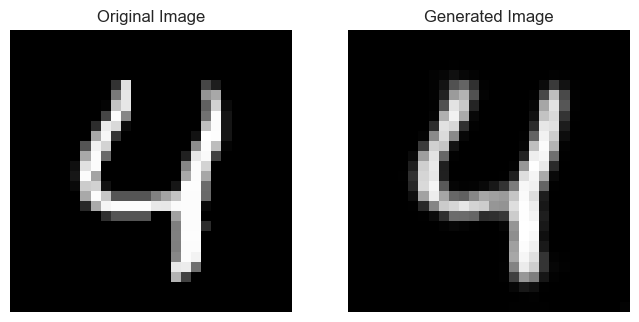

In [ ]:
from visualize import visualize_img
#Run this for AE Output comparison with original samples
# Assuming `decoder_output` is the tensor generated by your decoder
data_iter = iter(test_loader)
sample_batch = next(data_iter)
input_data =  sample_batch[0].to(device)

print(input_data.shape)
encoder_output = AEmodel.encoder(input_data)
print(encoder_output.shape)
decoder_output = AEmodel.decoder(encoder_output)
print(decoder_output.shape)
# Convert the tensor to a NumPy array
generated_image_np = decoder_output[4].detach().cpu().numpy()
#generated_image_np.reshape()
# Reshape the array if needed (remove the batch dimension if present)
generated_image_np = generated_image_np.reshape(generated_image_np.shape[1:])
print(generated_image_np.shape)
original_image = sample_batch[0][4].detach().cpu().numpy()
original_image = original_image.reshape(original_image.shape[1:])


visualize_img(original_image,generated_image_np)

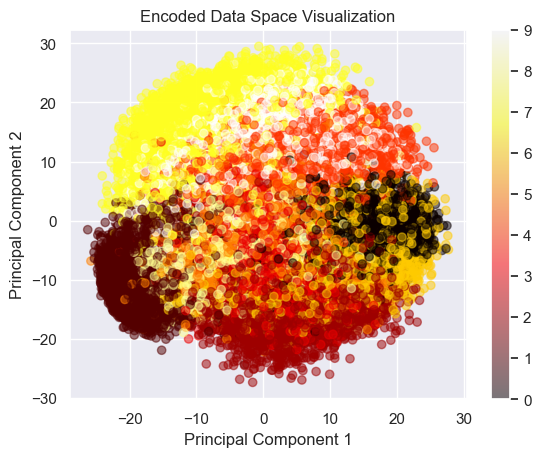

In [ ]:
from visualize import visualize_latent_space
visualize_latent_space(train_loader, AEmodel)

In [9]:
#Initialize VariationalAutoEncoder Model
VAEmodel = VariationalAutoEncoder()

#Learning Rate
alpha = 1e-03

#Define Optimizer
optimizer = torch.optim.Adam(VAEmodel.parameters(), lr=alpha)

loss = VAEmodel.vae_loss

VAEmodel.to(device)
print(VAEmodel)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (mean_layer): Linear(in_features=18432, out_features=256, bias=True)
  (log_var_layer): Linear(in_features=18432, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=18432, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 24, 24))
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
    (6): Sigmoid()
  )
  (BCELoss): BCELoss()
)


In [10]:
train_VAEmodel(VAEmodel,train_loader,val_loader, optimizer, loss, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\soupt\anaconda3\envs\MPL\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 1/10 [00:10<01:34, 10.48s/it]

RC Loss: 8932.3876953125
Epoch 1/10, Training Loss: 16067.1162, Validation Loss: 10976.4121


 20%|██        | 2/10 [00:20<01:22, 10.35s/it]

RC Loss: 8698.1484375
Epoch 2/10, Training Loss: 10631.7910, Validation Loss: 10331.5537


 30%|███       | 3/10 [00:30<01:11, 10.23s/it]

RC Loss: 8534.798828125
Epoch 3/10, Training Loss: 10293.9150, Validation Loss: 10135.3613


 40%|████      | 4/10 [00:41<01:01, 10.24s/it]

RC Loss: 8400.861328125
Epoch 4/10, Training Loss: 10110.7979, Validation Loss: 9995.2998


 50%|█████     | 5/10 [00:51<00:52, 10.46s/it]

RC Loss: 8244.8837890625
Epoch 5/10, Training Loss: 9989.5908, Validation Loss: 9904.0645


 60%|██████    | 6/10 [01:02<00:41, 10.47s/it]

RC Loss: 8215.080078125
Epoch 6/10, Training Loss: 9893.2861, Validation Loss: 9810.2510


 70%|███████   | 7/10 [01:12<00:30, 10.29s/it]

RC Loss: 8330.7548828125
Epoch 7/10, Training Loss: 9810.5410, Validation Loss: 9710.0771


 80%|████████  | 8/10 [01:23<00:20, 10.48s/it]

RC Loss: 8227.298828125
Epoch 8/10, Training Loss: 9739.5107, Validation Loss: 9668.8135


 90%|█████████ | 9/10 [01:34<00:10, 10.64s/it]

RC Loss: 8256.734375
Epoch 9/10, Training Loss: 9666.3770, Validation Loss: 9615.2285


100%|██████████| 10/10 [01:44<00:00, 10.48s/it]

RC Loss: 7965.751953125
Epoch 10/10, Training Loss: 9611.2012, Validation Loss: 9578.2539


(tensor(9611.2012, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(9578.2539, device='cuda:0'))

In [24]:
torch.save(VAEmodel.state_dict(), './saved/models/VAEModel_MNIST.pth')

In [20]:
from eval import eval_modelVAE
from visualize import visualize_latent_space,visualize_img

In [17]:
eval_modelVAE(VAEmodel, test_loader, loss)

c:\Users\soupt\anaconda3\envs\MPL\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Loss: 9469.0811


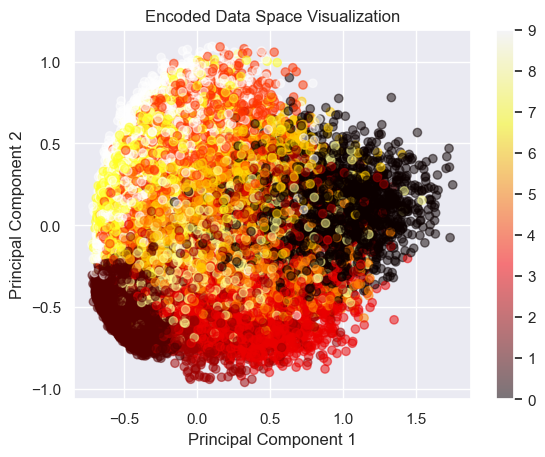

In [18]:
visualize_latent_space(train_loader, VAEmodel)

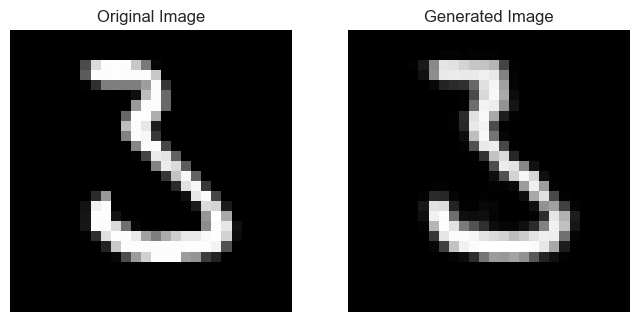

In [23]:
import numpy as np
import random
VAEmodel.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.view(-1, 1,  28, 28)
        imgs = imgs.float()
        imgs = imgs.to(device)
        out, mu, logVAR = VAEmodel(imgs)
        visualize_img(imgs[0, 0].cpu().numpy(), out[0, 0].cpu().numpy())
        break